In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft,fftfreq,fftshift

In [51]:
# Now that the simplified version works, I want to build a more general version of this.
# This includes a different number of substates, differentiation between the transitions that model the refractory period and the last transition

def generate_residency_times(transition_rate: int, number_of_substates: int):
    residency_times = []
    rng = np.random.default_rng()
    residency_times = rng.exponential(scale = (1/transition_rate),size = number_of_substates)
    return residency_times

def two_state_process_advanced(number_of_substates: list, transition_rates: list, refractory_periods: list, total_time: float, delta_t: float):
    current_time = 0.0
    target_sequence_length = int(total_time/delta_t)
    initial_state = -1.0
    current_state = initial_state

    state_sequence = []

    transition_rate_substates_A = (number_of_substates[0]-1)/refractory_periods[0]      # in both cases for N substates we have N-1 transitions that approximate the refractory period
    transition_rate_substates_B = (number_of_substates[1]-1)/refractory_periods[1]


    while len(state_sequence) < target_sequence_length:
        # go through chain for state -1
        residency_times = generate_residency_times(transition_rate_substates_A,number_of_substates[0]-1)     #We take number of substates -1 here, because we want to generate the last residdency time independently from the others
        for time in residency_times:
            truncated_time = np.round(time,int(-np.log10(delta_t)))
            number_of_occurence = int(truncated_time/delta_t)
            state_sequence.extend([current_state for _ in range(number_of_occurence)])
            current_state += (1 / number_of_substates[0])
            current_time += truncated_time

        # generate last residency time according to transition rate
        last_residency_time = generate_residency_times(transition_rates[0],number_of_substates=None)
        truncated_time = np.round(last_residency_time,int(-np.log10(delta_t)))
        number_of_occurence = int(truncated_time/delta_t)
        state_sequence.extend([current_state for _ in range(number_of_occurence)])
        current_state += (1 / number_of_substates[0])
        current_time += truncated_time

        # go through chain for state 1
        residency_times = generate_residency_times(transition_rate_substates_B,number_of_substates[1]-1)
        current_state = (1 / number_of_substates[1])

        for time in residency_times:
            truncated_time = np.round(time,int(-np.log10(delta_t)))
            number_of_occurence = int(truncated_time/delta_t)
            state_sequence.extend([current_state for _ in range(number_of_occurence)])
            current_state += (1 / number_of_substates[1])
            current_time += truncated_time

        # generate last residency time according to transition rate
        last_residency_time = generate_residency_times(transition_rates[1],number_of_substates=None)
        truncated_time = np.round(last_residency_time,int(-np.log10(delta_t)))
        number_of_occurence = int(truncated_time/delta_t)
        state_sequence.extend([current_state for _ in range(number_of_occurence)])
        current_state += (1 / number_of_substates[1])
        current_time += truncated_time
        
        # loop back around to initial state -1
        current_state = -1.0

    state_sequence = state_sequence[:target_sequence_length]
    time_sequence = [delta_t*i for i in range(len(state_sequence))]

    return time_sequence,state_sequence



In [52]:
# def function that hides the sequence of substates and identifies them with their "parent state" -1 or 1
def reduce_states(sample_states):
    """
    Takes as input the array that contains the sequence of plotable states and identifies them with super states.

    """
    sample_state_reduced = []
    
    for i,state in enumerate(sample_states):
        if state < 0:
            sample_state_reduced.append(-1)
        else:
            sample_state_reduced.append(1)
    return sample_state_reduced

def two_state_process_reduced(two_state_process_advanced, *args, **kwargs):
    time_sequence,state_sequence = two_state_process_advanced(*args, **kwargs)
    state_sequence = reduce_states(state_sequence)
    return time_sequence,state_sequence

#the following function guarantees that the eigenvector that is chosen is a probability density, i.e. positive and normed to one
def norm_to_probability_density(x: np.array):
    if np.argmax(x) < 0:                   
        x = -x            
    x = 1/(np.sum(x)) * x
    return x

In [53]:
def build_generator_matrix(number_of_substates: list, transition_rates: list, refractory_periods: list):
    """
    Constructs the generator matrix (L) for the two-state renewal process
    with linear chains to model refractory periods.
    
    Args:
        number_of_substates (list): [N, M], the number of substates for state A and B.
        transition_rates (list): The final transition rates out of state A and B.
        refractory_periods (list): The desired mean refractory period for state A and B.

    Returns:
        array: The (N+M)x(N+M) generator matrix L.
    """
    #Define relevant parameters
    N = number_of_substates[0]
    M = number_of_substates[1]

    total_states = N + M

    transition_rates_substates_A = (N-1) / refractory_periods[0]
    transition_rates_substates_B = (M-1) / refractory_periods[1]

    transition_rate_final_A = transition_rates[0]
    transition_rate_final_B = transition_rates[1]

    #Initialize matrix
    L = np.zeros((total_states,total_states))

    for i in range(N-1):
        L[i,i] = (-1 * transition_rates_substates_A)
        L[i+1,i] = transition_rates_substates_A
    
    L[N-1,N-1] = (-1 * transition_rate_final_A)
    L[N,N-1] = transition_rate_final_A

    for i in range(N,N+M-1):
        L[i,i] = (-1 * transition_rates_substates_B)
        L[i+1,i] = transition_rates_substates_B

    L[N+M-1,N+M-1] = (-1 * transition_rate_final_B)
    L[0,N+M-1] = transition_rate_final_B

    return L


def calculate_and_order_eigenspectrum(L: np.array):
    """
    Calculates and plots the eigenvalues of the generator matrix L.

    Args:  generator matrix L
    """
    #calculate lefthand eigenvalues
    eigenvalues_left_raw, eigenvectors_left = np.linalg.eig(L.T)     #since we want the lefthand eigenvectors, we take transpose the matrix here
    #Order eigenvalues by magnitude of real part. The resulting array starts with eigenvalues that have the most negative real part. 
    index_ordering = np.argsort(eigenvalues_left_raw.real)
    eigenvalues_left = eigenvalues_left_raw[index_ordering]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_left)-1):
        if eigenvalues_left[i].real == eigenvalues_left[i+1].real:
            if eigenvalues_left[i].imag > eigenvalues_left[i+1].imag:
                temp = index_ordering[i]
                index_ordering[i] = index_ordering[i+1]
                index_ordering[i+1] = temp
            else: continue
    eigenvalues_left = eigenvalues_left_raw[index_ordering]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_left = []
    for i in index_ordering:
        ordered_eigenvectors_left.append(eigenvectors_left[:,i])

    #Norm stationary left eigenvector to all ones
    for i in range(len(ordered_eigenvectors_left[-1])):
        ordered_eigenvectors_left[-1][i] = np.abs(1/(ordered_eigenvectors_left[-1][i]) * ordered_eigenvectors_left[-1][i])
    

    ################################################

    #calculate righthand eigenvalues
    eigenvalues_right_raw, eigenvectors_right = np.linalg.eig(L)
    
    idx_order = np.argsort(eigenvalues_right_raw.real)
    eigenvalues_right = eigenvalues_right_raw[idx_order]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_right)-1):
        if eigenvalues_right[i].real == eigenvalues_right[i+1].real:
            if eigenvalues_right[i].imag > eigenvalues_right[i+1].imag:
                temp = idx_order[i]
                idx_order[i] = idx_order[i+1]
                idx_order[i+1] = temp
            else: continue
    eigenvalues_right = eigenvalues_right_raw[idx_order]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_right = []
    for i in idx_order:
        ordered_eigenvectors_right.append(eigenvectors_right[:,i])

    #Norm stationary right eigenvector so that it is a probability distribution
    ordered_eigenvectors_right[-1] = norm_to_probability_density(ordered_eigenvectors_right[-1])

    #Norm the left eigenvectors Q_i to unit variance, as detailed in the paper eq. 9
    for i in range(len(ordered_eigenvectors_left)-1):
        variance = 0
        for j in range(len(ordered_eigenvectors_left[i])):
            variance += np.abs(ordered_eigenvectors_left[i][j])**2 * ordered_eigenvectors_right[-1][j]
        ordered_eigenvectors_left[i] = (1/np.sqrt(variance)) * ordered_eigenvectors_left[i]

    #Enforce biorthogonality 
    for i in range(len(ordered_eigenvectors_right)-1):
        dot_product = ordered_eigenvectors_right[i]@ordered_eigenvectors_left[i]
        ordered_eigenvectors_right[i] = (1/dot_product) * ordered_eigenvectors_right[i]

    return eigenvalues_left,ordered_eigenvectors_left,ordered_eigenvectors_right

def analyzing_and_plotting_eigenspectrum(ordered_eigenvalues, ordered_eigenvectors_left, ordered_eigenvectors_right):
    stationary_eigenvalue = ordered_eigenvalues[-1]

    #the eigenvalue of interest is the eigenvalue with the the largest non-zero real part
    lambda_1 = ordered_eigenvalues[-2]
    mu_1 = lambda_1.real
    omega_1 = lambda_1.imag

    #stationary left eigenvector
    Q_0 = ordered_eigenvectors_left[-1]
    #the following line guarantee that the eigenvalue that is chosen is a probability density, i.e. positive and normed to one

    #the left eigenvector Q_1 that corresponds to the lambda_1
    Q_1 = ordered_eigenvectors_left[-2]
    #Q_1 = norm_to_probability_density(Q_1)
    
    sum_entries_Q_0 = np.sum(Q_0)
    sum_entries_Q_1 = np.sum(Q_1)

    #stationary right eigenvector
    P_0 = ordered_eigenvectors_right[-1]
    #P_0 = norm_to_probability_density(P_0)

    #the right eigenvector P_1 that corresponds to the lambda_1
    P_1 = ordered_eigenvectors_right[-2]
    #P_1 = norm_to_probability_density(Q_1)
    
    sum_entries_P_0 = np.sum(P_0)
    sum_entries_P_1 = np.sum(P_1)


    print("-" * 30)
    print(f"Number of eigenvalues: {len(ordered_eigenvalues)}")
    print(f"Stationary Eigenvalue: {stationary_eigenvalue:.4f}")
    print(f"Oscillatory Eigenvalue (λ₁): {lambda_1:.4f}")
    print(f"Quality factor: {np.abs(omega_1/mu_1)}")
    print("-" * 30)
    print(f"Stationary lefthand Eigenvector: {Q_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary lefthand eigenvector: {sum_entries_Q_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (Q₁): {Q_1}")
    print(" " * 30)
    print(f"Sum of elements of Q₁: {sum_entries_Q_1}")
    print("-" * 30)
    print(f"Stationary righthand Eigenvector: {P_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary righthand eigenvector: {sum_entries_P_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (P₁): {P_1}")
    print(" " * 30)
    print(f"Sum of elements of P₁: {sum_entries_P_1}")


    #Plotting

    # Plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot all eigenvalues
    ax.scatter(ordered_eigenvalues.real, ordered_eigenvalues.imag, c='teal', alpha=0.6, label='Other Eigenvalues')
    ax.scatter(ordered_eigenvalues.real, -ordered_eigenvalues.imag, c='teal', alpha=0.6) # Plot conjugates

    #Highlight eigenvalue with largest non-zero real part
    ax.scatter(lambda_1.real, lambda_1.imag, c='red', alpha=1, s=150, label=f'$\lambda_1$ = {mu_1:.2f} + {omega_1:.2f}i')
    ax.scatter(lambda_1.real, -lambda_1.imag, c='red', alpha=1, s=150) # Plot conjugates

    # Annotate the plot
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)
    ax.set_xlim(-8.5, 0 + 0.5)
    ax.set_xlabel("Re(λ)", fontsize=14)
    ax.set_ylabel("Im(λ)", fontsize=14)
    ax.set_title("Eigenvalue Spectrum of the Generator Matrix", fontsize=16, weight='bold')
    ax.legend(fontsize=12)
    ax.grid(True)

    plt.show()


In [54]:
#calculate the conditional transition probability from the obtained eigenvetors
def transition_probability(eigenvalues: list, left_eigenvectors: list, right_eigenvectors: list ,initial_state: int,target_state: int,time: float):
        spectral_sum = 0
        for i in range(len(left_eigenvectors)-1):
            spectral_sum += np.exp(eigenvalues[i] * time) * right_eigenvectors[i][target_state] * left_eigenvectors[i][initial_state]
        return right_eigenvectors[-1][target_state] + spectral_sum

In [55]:
#define function that calculates power spectrum for given sequence of time and states by averaging over many realizations of the process
def power_spectrum(process_generator, realizations: int, *args, **kwargs):
    #process generator must return two arrays, one time sequence and one state sequence
    #call process generator once to initialize variables:
    time_sequence,state_sequence = process_generator(*args,**kwargs)
    #state_sequence = reduce_states(state_sequence)                              ####   if this line is uncommented the power spectrum of the superstates is calculated 
    number_sample_points = len(time_sequence)
    dt = time_sequence[1]-time_sequence[0]
    average = np.zeros(number_sample_points)
    #calculate first iteration with initialized variables
    ft_state_sequence = fft(state_sequence)*dt
    average += np.abs(ft_state_sequence)**2

    #calculate ensemble average over remaining realizations
    for i in range(1,realizations):
        time_sequence,state_sequence = process_generator(*args,**kwargs)
        #state_sequence = reduce_states(state_sequence)                          ####   if this line is uncommented the power spectrum of the superstates is calculated
        ft_state_sequence = fft(state_sequence)*dt
        if len(average) == len(ft_state_sequence):
            average += np.abs(ft_state_sequence)**2
        else: 
            print(f'Flag for realisation {i}')
            print(f'Mismatch: {len(average)} is not equal to {len(ft_state_sequence)}')

    #calculate final outputs
    frequency_sequence = fftfreq(number_sample_points,dt)
    power_spectrum_sequence = average/(realizations * (len(time_sequence)*dt))

    return frequency_sequence,power_spectrum_sequence

In [56]:
def phase_reduction(state_sequence: list, Q_1: np.array):
    
    Q_1_sequence = np.zeros(len(state_sequence), dtype=np.complex128)

    
    for i in range(len(state_sequence)):
        #reconstruct the state index from the trajectory value
        ### this assumes that the initial state is -1 and the indexing increases monotonically until state 1 is reached, i.e. -1 has index 0 and 1 has index 19
        x = state_sequence[i]
        if x < 0:
            advancement = np.abs(x - state_sequence[0])
            state_index = int(10*advancement)
        elif x > 0:
            advancement = x
            state_index = int(10*advancement + 9)
        
        #assign calculated Q_1 value
        Q_1_sequence[i] = Q_1[state_index]
        
        complex_argument_Q_1 = np.angle(Q_1_sequence)

    return Q_1_sequence

def phase_reduced_process(time_sequence: list, state_sequence:list, Q_1: np.array):

    complex_argument_Q_1 = phase_reduction(state_sequence, Q_1)

    return time_sequence, complex_argument_Q_1


In [57]:
#the theoretically expected power spectrum of Q_1
def power_spectrum_theoretical_Q_1(eigenvalue: np.complex128, omega: float):
    mu_1 = eigenvalue.real
    omega_1 = eigenvalue.imag
    return (2*np.abs(mu_1)) / (mu_1**2 + (omega - omega_1)**2)

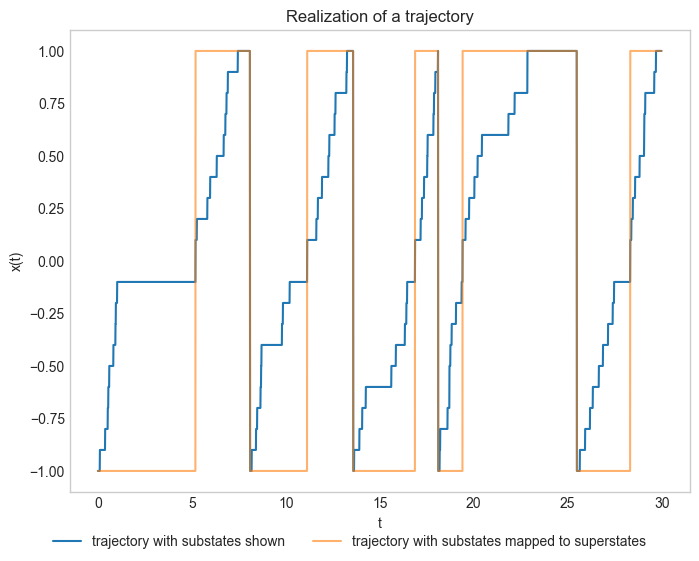

------------------------------
Number of eigenvalues: 20
Stationary Eigenvalue: -0.0000+0.0000j
Oscillatory Eigenvalue (λ₁): -0.2541+1.0527j
Quality factor: 4.142223222100159
------------------------------
Stationary lefthand Eigenvector: [1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
                              
Sum of elements of stationary lefthand eigenvector: (20+0j)
                              
Oscillatory Eigenvector (Q₁): [-1.1644088 -3.96443851e-15j -1.09865061-2.72385112e-01j
 -0.97288814-5.14005165e-01j -0.79770678-7.12561027e-01j
 -0.5859712 -8.58924336e-01j -0.35195493-9.47491614e-01j
 -0.1104362 -9.76314778e-01j  0.1241856 -9.47012768e-01j
  0.33870301-8.64481481e-01j  0.52179969-7.36429892e-01j
  1.1644088 +0.00000000e+00j  1.09865061+2.72385112e-01j
  0.97288814+5.14005165e-01j  0.79770678+7.12561027e-01j
  0.5859712 +8.58924336e-01j  0.35195493+9.47491614e-01j
  0.110436

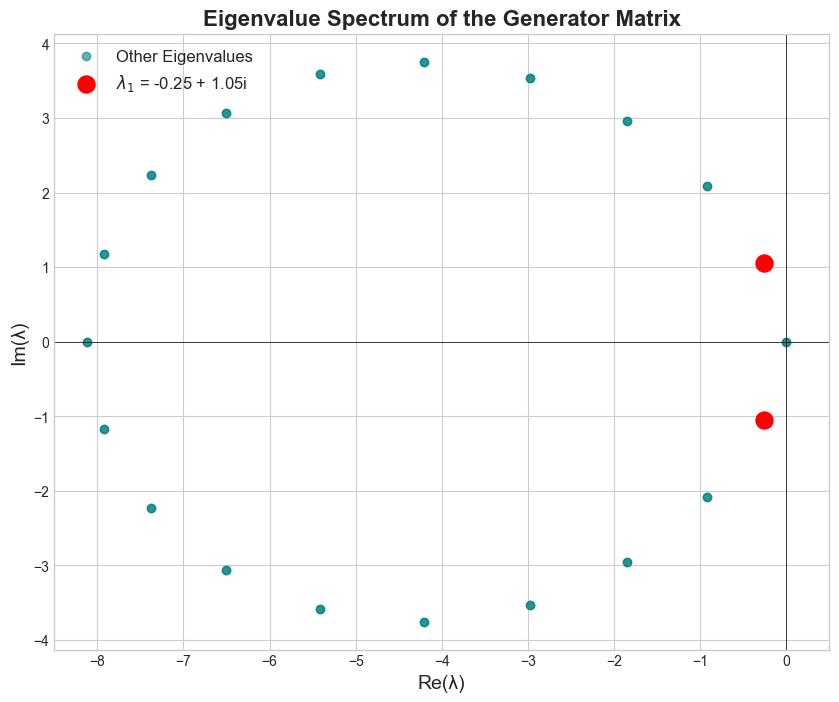

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


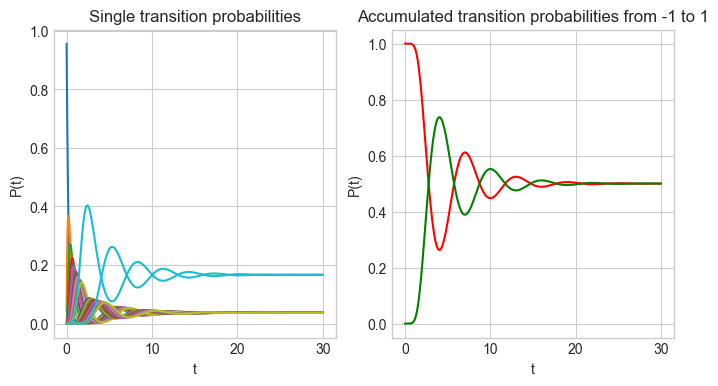

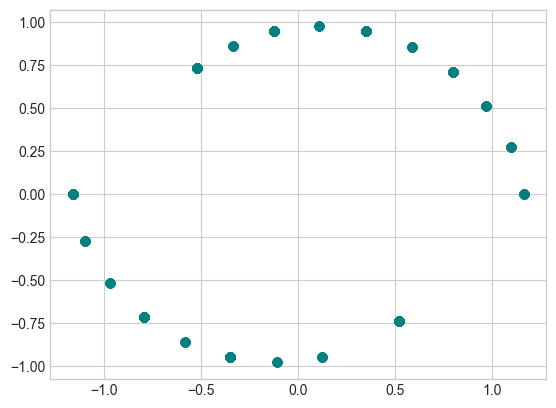

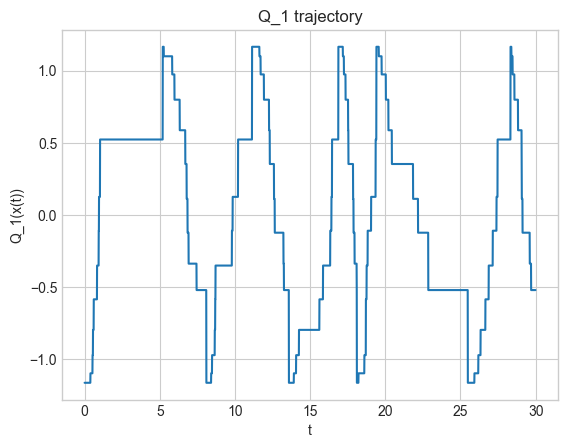

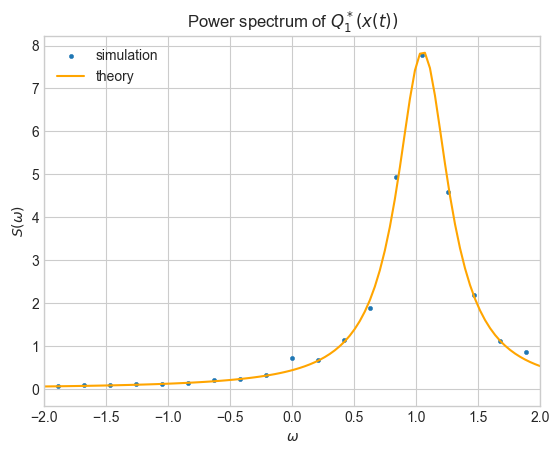

In [60]:
# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 30
delta_t = 0.01

#Plot a trajectory for the given parameters
# Create a figure
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
generated_time_sequence, generated_state_trajectory = two_state_process_advanced(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
ax1.set_title('Realization of a trajectory')
ax1.plot(generated_time_sequence, generated_state_trajectory, label='trajectory with substates shown')


#Plot reduced trajectory for the given parameters
reduced_state_trajectory = reduce_states(generated_state_trajectory)
ax1.plot(generated_time_sequence, reduced_state_trajectory, label='trajectory with substates mapped to superstates', alpha = 0.6)
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.grid(False)
fig.legend(loc='lower center', ncols = 2)
plt.show()

#Build generator matrix
L = build_generator_matrix(number_of_substates,transition_rates,refractory_periods)

#Calculate eigenspectrum
eigenvals,Q,P = calculate_and_order_eigenspectrum(L)
#Analyze and plot eigenspectrum
analyzing_and_plotting_eigenspectrum(eigenvals,Q,P)

#Plot transition probability over time for a specific pair of states
fig2, (ax1,ax2) = plt.subplots(1,2,figsize = (8,4))
ax1.set_title('Single transition probabilities')
ax1.set_xlabel('t')
ax1.set_ylabel('P(t)')
for i in range(20):
    generated_transition_probability = [transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence]
    ax1.plot(generated_time_sequence,generated_transition_probability)

ax2.set_title('Accumulated transition probabilities from -1 to 1')
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')

accum_transition_probability_A = [0 for time in generated_time_sequence]
accum_transition_probability_B = [0 for time in generated_time_sequence]
for i in range(10):
    accum_transition_probability_A = np.add(accum_transition_probability_A,[transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence])
    accum_transition_probability_B = np.add(accum_transition_probability_B,[transition_probability(eigenvals,Q,P,0,i+10,time+0.01) for time in generated_time_sequence])
ax2.plot(generated_time_sequence,accum_transition_probability_A,color='red')
ax2.plot(generated_time_sequence,accum_transition_probability_B,color='green')
plt.show()

#Perform transformation to Q_1:
Q_1_sequence = phase_reduction(generated_state_trajectory,Q[-2])
plt.scatter(Q_1_sequence.real, Q_1_sequence.imag, c='teal', alpha=0.6)
plt.show()
#complex_argument = np.angle(Q_1_sequence)
plt.plot(generated_time_sequence,Q_1_sequence)
plt.title('Q_1 trajectory')
plt.xlabel('t')
plt.ylabel('Q_1(x(t))')
plt.show()

#Plot power spectrum Q_1(t):
f,S = power_spectrum(phase_reduced_process, 1, generated_time_sequence, generated_state_trajectory, Q[-2])
accum = np.zeros(len(S)) 
for i in range(100):
    generated_time_sequence, generated_state_trajectory = two_state_process_advanced(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
    S = power_spectrum(phase_reduced_process, 1, generated_time_sequence, generated_state_trajectory, Q[-2])[1]
    accum += S
accum = 1/100 * accum
l = len(f)
f_shifted = fftshift(f)
#the theoretical formula is given for an angular frequency omega, so we have to convert the frequency into the angular frequency
omega = 2*np.pi * f_shifted
omega_plot = np.linspace(-2,2,100)
accum_shifted = fftshift(accum)
plt.scatter(omega,accum_shifted,linewidths=0.4, marker='.', label='simulation')
plt.plot(omega_plot,[power_spectrum_theoretical_Q_1(eigenvals[-2],x) for x in omega_plot],color='orange', label='theory')
plt.xlim(-2,2)
plt.title('Power spectrum of $Q_1^*(x(t))$')
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.legend()
plt.show()


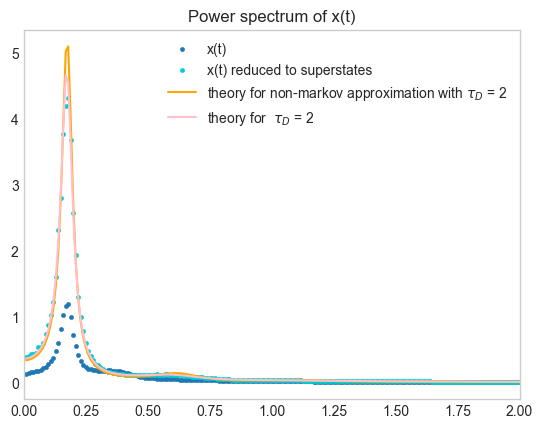

In [11]:
### Testing the power spectrum function for the trajectory and compare it with the non markovian version of the two state porcess
### Qualitatively the function works in this case but the scaling is of. On the point distribution it worked though. So the question remains if the function is off for some unknown reason
### or if our markovian process behaves differently

### ANSWER: The different value assignment of the substates changes the value of the power spectrum. If the substates are identified with its superstate, then the power spectra are the same

# Parameters
N = 50
M = 50
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 100
delta_t = 0.01
sim_params = [number_of_substates,number_of_substates,refractory_periods,total_time,delta_t]

# define theoretical power spectrum for non-markovian process that is approximated
def S_approx(f,tau_D):
    return 0.5 * (((1+1)**2 * 1**2)/(1+tau_D)) / (1 + np.cos(2*np.pi*f*tau_D) - 2*np.pi*f*1*np.sin(2*np.pi*f*tau_D) + 2*(np.pi*f*1)**2)

# define theoretical power spectrum for markovian process that we actually have
def S(f: float, refractory_periods:list, final_transition_rates:list, number_of_substates:list):
    N = number_of_substates[0]
    M = number_of_substates[1]
    lambda_A = (N-1)/refractory_periods[0]
    lambda_B = (M-1)/refractory_periods[1]
    lambda_N = final_transition_rates[0]
    lambda_M = final_transition_rates[1]
    FT_rho_A = (lambda_A / (2j*np.pi*f + lambda_A))**(N-1) * (lambda_N/(2j*np.pi*f + lambda_N))
    FT_rho_B = (lambda_B / (2j*np.pi*f + lambda_B))**(M-1) * (lambda_M/(2j*np.pi*f + lambda_M))

    val_super_A = 1
    val_super_B = -1
    mean_residency_time_A = refractory_periods[0] + 1/lambda_N
    mean_residency_time_B = refractory_periods[1] + 1/lambda_M

    S = (2*(val_super_A - val_super_B)**2)/((mean_residency_time_A + mean_residency_time_B)*(2*np.pi*f)**2)  * ((1-FT_rho_A)*(1-FT_rho_B)/(1-FT_rho_A*FT_rho_B)).real
    
    return S

f,psd = power_spectrum(two_state_process_advanced,1000,number_of_substates,transition_rates,refractory_periods,total_time,delta_t)
psd2 = power_spectrum(two_state_process_reduced,1000,two_state_process_advanced, number_of_substates,transition_rates,refractory_periods,total_time,delta_t)[1]
N = len(f)
plt.xlim(0,2)
plt.scatter(f[1:N//2],psd[1:N//2],linewidths=0.4, marker='.', label='x(t)')
plt.scatter(f[1:N//2],psd2[1:N//2],linewidths=0.4, marker='.', color = 'darkturquoise', label = 'x(t) reduced to superstates')
plt.plot(f[1:N//2],[S_approx(x,2) for x in f[1:N//2]], label=f'theory for non-markov approximation with $\\tau_D$ = {2}', color = 'orange')
plt.plot(f[1:N//2],[S(x,refractory_periods, transition_rates, number_of_substates) for x in f[1:N//2]], label=f'theory for  $\\tau_D$ = {2}', color = 'pink')
plt.title('Power spectrum of x(t)')
plt.legend()
plt.grid(False)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


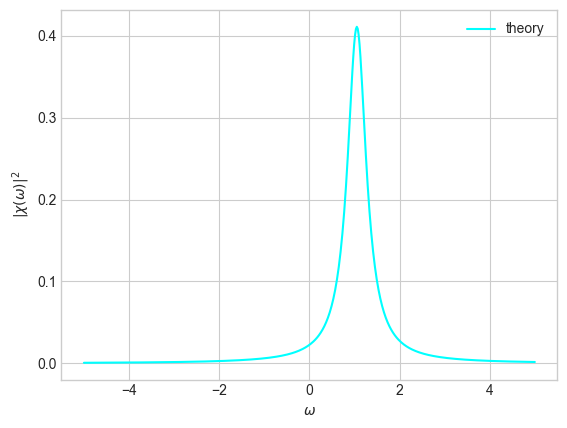

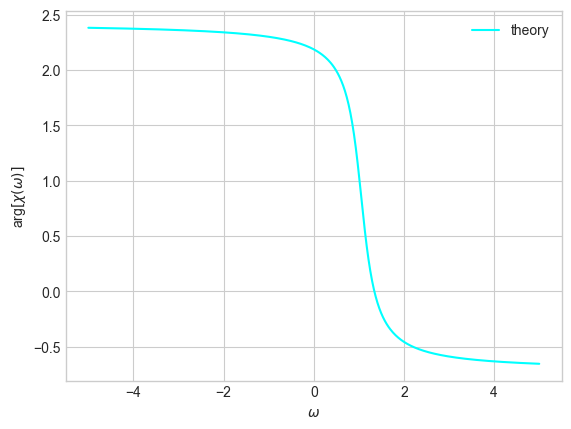

In [ ]:
### This section aims at calculating the linear response function and the susceptibility of the system for the first left hand eigenvector

# First we define the perturbation
# We want something like a sinusoidal modification of one transition rate
# We choose the last state of the first linear chain to be perturbed
perturbed_state_index = 9
def perturbation_force(t):
    return np.sin(t)
epsilon = 0.1
# Construct perturbation matrix
L_prime = np.zeros(np.shape(L))
L_prime[perturbed_state_index+1,perturbed_state_index] = 1
L_prime[perturbed_state_index,perturbed_state_index] = -1

# Since L_perturbed is now a time dependent linear transformation we have to define is as a function:
def L_perturbed(t):
    return epsilon * perturbation_force(t) * L_prime

# With that we can calculate the coefficient beta of the linear response function
beta = 0
for i in range(len(P[-1])):
    beta += Q[-2][i] * (L_prime @ P[-1])[i]


# The susceptibility is then defined by:
def chi(omega):
    return (beta)/(-eigenvals[-2].real + 1j * (omega-eigenvals[-2].imag))


### -------
# Simulation:

# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 30
delta_t = 0.01

#Plot a trajectory for the given parameters
# Create a figure
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
generated_time_sequence, generated_state_trajectory = two_state_process_advanced(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
ax1.set_title('Realization of a trajectory')
ax1.plot(generated_time_sequence, generated_state_trajectory, label='trajectory with substates shown')


#Plot reduced trajectory for the given parameters
reduced_state_trajectory = reduce_states(generated_state_trajectory)
ax1.plot(generated_time_sequence, reduced_state_trajectory, label='trajectory with substates mapped to superstates', alpha = 0.6)
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.grid(False)
fig.legend(loc='lower center', ncols = 2)
plt.show()

### -------



# Plot abs valued squared of chi as well as complex argument
freq_space = np.linspace(-5,5,500)
abs_value_squared_chi_vals = [chi(omega) * np.conjugate(chi(omega)) for omega in freq_space]
complex_arg_chi_vals = [np.angle(chi(omega)) for omega in freq_space]


plt.plot(freq_space, abs_value_squared_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('$|\chi(\omega)|^2$')
plt.legend()
#plt.vlines(eigenvals[-2].imag, ymin=0, ymax=0.5).     #shows that susceptibility is maximal if perturbation has same frequency as system itself
plt.show()

plt.plot(freq_space, complex_arg_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('arg$[\chi(\omega)]$')
plt.legend()
plt.show()
